# Spatial omics analysis

For this project, we are going to follow this tutorial here: https://www.sc-best-practices.org/spatial/domains.html and https://www.sc-best-practices.org/spatial/neighborhood.html.

In the tutorial, they used spatial Gene Expression dataset of Mouse Brain Section (Coronal) (https://www.10xgenomics.com/datasets/mouse-brain-section-coronal-1-standard). For the project, we will be using the other section of the Mouse Brain (https://www.10xgenomics.com/datasets/mouse-brain-coronal-section-1-ffpe-2-standard). Feel free to explore the datasets in the website by clicking `view summary`.


In [ ]:
!pip install igraph
!pip install leidenalg
!pip install scanpy
!pip install squidpy
!pip install numcodecs==0.10.2

First, download the files:
 [1] https://cf.10xgenomics.com/samples/spatial-exp/2.0.0/CytAssist_FFPE_Mouse_Brain_Rep1/CytAssist_FFPE_Mouse_Brain_Rep1_filtered_feature_bc_matrix.h5 (Feature/barcode matrix HDF5(filtered));  <br>
 [2] https://cf.10xgenomics.com/samples/spatial-exp/1.3.0/Visium_Adult_Mouse_Brain/Visium_Adult_Mouse_Brain_spatial.tar.gz (Spatial imaging analysis); <br>
 [3] https://cf.10xgenomics.com/samples/spatial-exp/2.0.0/CytAssist_FFPE_Mouse_Brain_Rep1/CytAssist_FFPE_Mouse_Brain_Rep1_analysis.tar.gz (Clustering analysis) from 10xgenomics website and read the feature matrix and image with `scanpy.read_visium`. Your folder should look like this:

```pgsql
your_sample_folder/
│   ├── tissue_hires_image.png
│   ├── scalefactors_json.json
│   └── tissue_positions.csv   (or tissue_positions_list.csv)
├── filtered_feature_bc_matrix.h5
├── clusters.csv
```

In [16]:
import scanpy as sc
import squidpy as sq
import igraph
import leidenalg
import pandas as pd

upload your sample folder to your google drive and then mount it.

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80, facecolor="white")

In [23]:
adata = sc.read_visium("/content/drive/MyDrive/sample")
cluster = pd.read_csv("/content/drive/MyDrive/sample/clusters.csv", index_col="Barcode")
adata.obs = adata.obs.join(cluster, how="left")

reading /content/drive/MyDrive/sample/filtered_feature_bc_matrix.h5
 (0:00:01)


/usr/local/lib/python3.11/dist-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.11/dist-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [24]:
adata

AnnData object with n_obs × n_vars = 2310 × 19465
    obs: 'in_tissue', 'array_row', 'array_col', 'Cluster'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [25]:
# nearest neighbor graph
sc.pp.neighbors(adata)
nn_graph_genes = adata.obsp["connectivities"]
# spatial proximity graph
sq.gr.spatial_neighbors(adata)
nn_graph_space = adata.obsp["spatial_connectivities"]

computing neighbors
computing PCA
    with n_comps=50


/usr/local/lib/python3.11/dist-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 19465 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


    finished (0:00:13)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:14)
Creating graph using `grid` coordinates and `None` transform and `1` libraries.
Adding `adata.obsp['spatial_connectivities']`
       `adata.obsp['spatial_distances']`
       `adata.uns['spatial_neighbors']`
Finish (0:00:00)


In [26]:
alpha = 0.2
joint_graph = (1 - alpha) * nn_graph_genes + alpha * nn_graph_space
sc.tl.leiden(adata, adjacency=joint_graph, key_added="squidpy_domains")

running Leiden clustering
    finished: found 12 clusters and added
    'squidpy_domains', the cluster labels (adata.obs, categorical) (0:00:00)


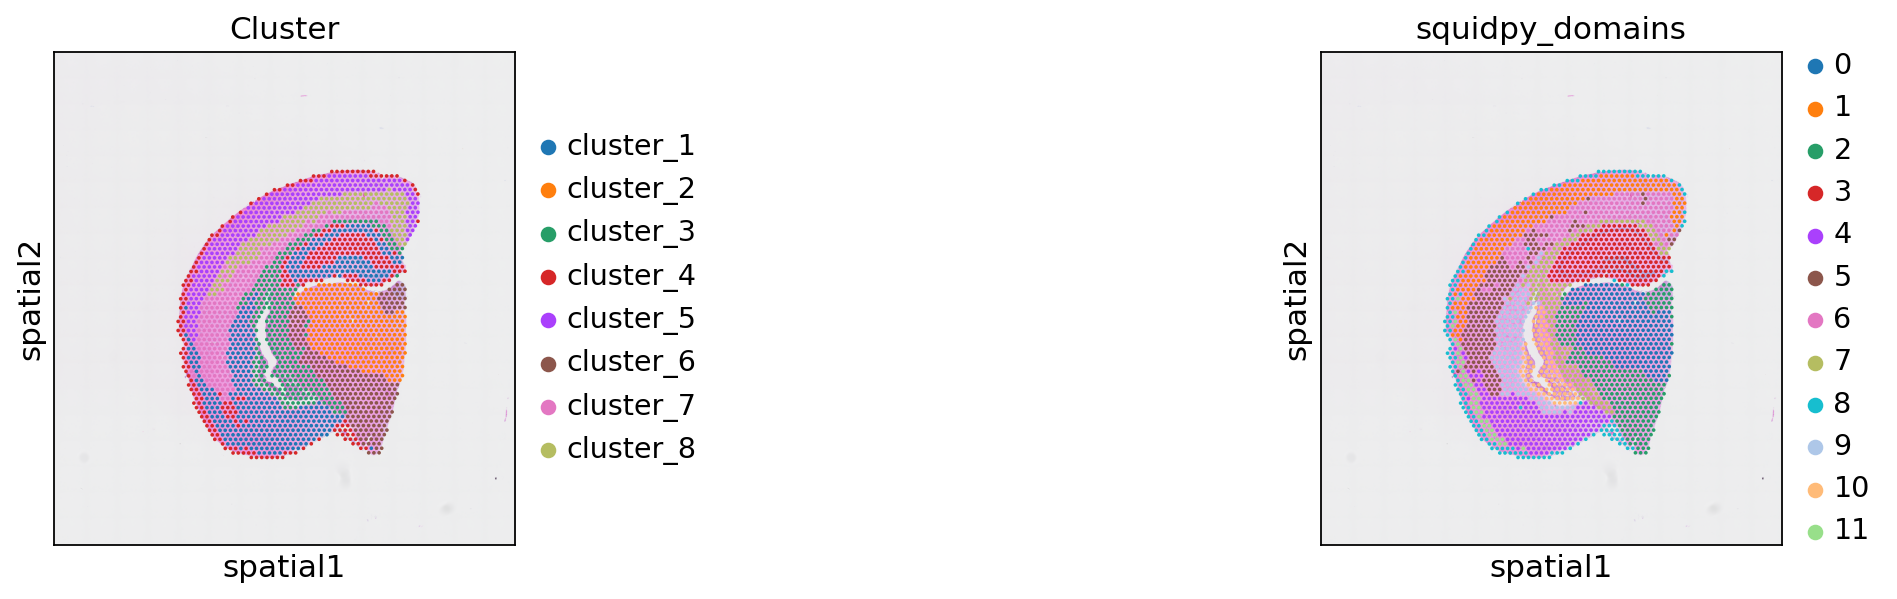

In [27]:
adata.obs["Cluster"] = "cluster" + "_" + adata.obs["Cluster"].astype(str)
sq.pl.spatial_scatter(adata, color=["Cluster","squidpy_domains"], wspace=0.9)